In [ ]:
library(ggraph)
library(igraph)
library(binaryLogic)
library(tidygraph)
library(tidyr)
library(dplyr)
library(graphlayouts)
library(stringr)
library(gganimate)
library(readr)

In [51]:
# Adjust this to choose file
filename1 <- "xeqi.csv"
filename2 <- "pop_sizes_orig.csv"

# Adjust this to choose timepoint for snapshot
time_point <- 13000

# Adjust these to determine time range for animation
lower_time_bound <- 8000
upper_time_bound <- 15000

In [52]:
# Helper for converting node ids to labels
make_label <- function(x) {paste(as.character(as.binary(x-1, n=4)), collapse="")}
# Helper for finding y coordinate based on node id
get_y <- function(x){sum(as.vector(as.binary(x-1)))}

# Deal with ugly ggraph interal stuff
make_layout <- function() {
  adjmat <- read.csv("adj_mat.csv", header = FALSE)
  adjmat <- as.matrix(adjmat)
  landscape <- graph_from_adjacency_matrix(adjmat)
  layout <- create_layout(landscape, "stress")
  
  layout$y <- sapply(seq(16), get_y)
  layout$x <- c(4,6,5,7,3,6,3,6,2,2,5,5,1,3,2,4)
  layout$label <- sapply(layout$.ggraph.index, make_label) 
  return(layout)
}

# Sneakily add supplemental data to ggraph object
add_data_to_graph <- function(layout, df) {
  spread_pop_df <- df %>% spread(generation, pop)
  new_layout <- layout %>% full_join(spread_pop_df) %>% gather(-name, -circular, -label, -.ggraph.orig_index, -.ggraph.index, -x, -y, key="time", value="pop")    
  attr(new_layout, "graph") <- attr(layout, "graph")
  attr(new_layout, "circular") <- attr(layout, "circular")
  attr(new_layout, "class") <- attr(layout, "class")
  new_layout$time <- as.numeric(new_layout$time)
  return(new_layout)
}

# Read in file output by C++ code and convert it to correct format
prepare_file <- function(filename){
  pop_sizes <- read_csv(filename)
  df <- pop_sizes %>% gather(-generation, key="name", value="pop")
  df$name <- str_replace(df$name, "pop", "V")
  df$name <- str_replace(df$name, "[:digit:]+", function(x){return(as.numeric(x)+1)})
  return(df)
}

# Make an animation over time
make_temporal_animation <- function(filename, lower_time_bound, upper_time_bound, frame_freq = 10) {
  df <- prepare_file(filename)
  layout <- make_layout()
  data_layout <- add_data_to_graph(layout, df %>% filter(generation > lower_time_bound) %>% filter(generation < upper_time_bound) %>% filter(generation %% frame_freq == 0))
  ggraph(data_layout) + geom_edge_link(start_cap = circle(5, 'mm'), end_cap = circle(5, 'mm')) + geom_node_circle(aes(r=sf(pop)), fill="lightblue", color="lightblue") + theme_graph(background = "white") + geom_node_text(aes(label=label)) + transition_time(time)
}

# Make a figure of a single snapshot in time
make_snapshot <- function(filename, time_point) {
  df <- prepare_file(filename)
  layout <- make_layout()
  data_layout <- add_data_to_graph(layout, df %>% filter(generation == time_point))
  ggraph(data_layout) + geom_edge_link(start_cap = circle(5, 'mm'), end_cap = circle(5, 'mm')) + geom_node_circle(aes(r=sf(pop)), fill="lightblue", color="lightblue") + theme_graph(background = "white") + geom_node_text(aes(label=label))  
}

sf <- function(pp) {
    return((log10(pp+1))**2/75)
}

make_circle_overlay <- function(filename1, filename2, time_point) {
  layout <- make_layout()
  df1 <- prepare_file(filename1)
  df2 <- prepare_file(filename2)
  data_layout <- add_data_to_graph(layout, df1 %>% filter(generation == time_point))
  other_data_layout <- add_data_to_graph(layout, df2 %>% filter(generation == time_point))
  ggraph(data_layout) + geom_edge_link(edge_colour = "black", edge_alpha=0.2, start_cap = circle(5, 'mm'), end_cap = circle(5, 'mm')) + geom_node_circle(aes(r=sf(pop)), fill="blue", color=NA, alpha=.4, stroke=0) + geom_node_circle(data= other_data_layout, aes(r=sf(pop)), fill="red", color=NA, alpha=.4, stroke=0) + theme_graph(background = "white") + geom_node_text(aes(label=label))
}

Parsed with column specification:
cols(
  generation = col_double(),
  pop0 = col_double(),
  pop1 = col_double(),
  pop2 = col_double(),
  pop3 = col_double(),
  pop4 = col_double(),
  pop5 = col_double(),
  pop6 = col_double(),
  pop7 = col_double(),
  pop8 = col_double(),
  pop9 = col_double(),
  pop10 = col_double(),
  pop11 = col_double(),
  pop12 = col_double(),
  pop13 = col_double(),
  pop14 = col_double(),
  pop15 = col_double()
)
Parsed with column specification:
cols(
  generation = col_double(),
  pop0 = col_double(),
  pop1 = col_double(),
  pop2 = col_double(),
  pop3 = col_double(),
  pop4 = col_double(),
  pop5 = col_double(),
  pop6 = col_double(),
  pop7 = col_double(),
  pop8 = col_double(),
  pop9 = col_double(),
  pop10 = col_double(),
  pop11 = col_double(),
  pop12 = col_double(),
  pop13 = col_double(),
  pop14 = col_double(),
  pop15 = col_double()
)
Joining, by = "name"
Joining, by = "name"
Warning message:
“Ignoring unknown parameters: stroke”Warning message:

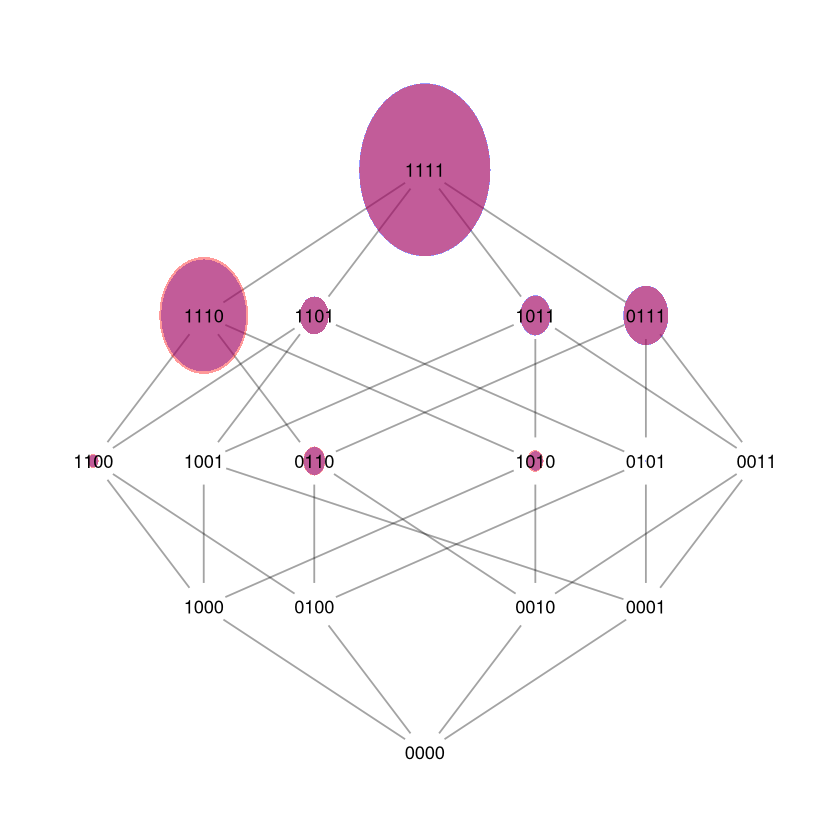

In [53]:
# Uncomment this line to make a temporal animation
# make_temporal_animation(filename1, lower_time_bound, upper_time_bound)

# This line makes a snapshot
#make_snapshot(filename1, time_point)

make_circle_overlay(filename1, filename2, time_point)

In [54]:
ggsave("tess_cd_13000.svg",width = 5, height = 3.8)